# **TUTORIAL - Topology Optimization**


---
---
## **Reference**

Andreassen, E., Clausen, A., Schevenels, M. *et al*. Efficient topology optimization in MATLAB using 88 lines of code. *Struct Multidisc Optim* **43**, 1–16 (2011). https://doi.org/10.1007/s00158-010-0594-7

---
---
## **Understanding Topology Optimization**


---
### **Categories of Structural Design Optimization**

<img src="https://drive.google.com/uc?export=view&id=1bdn910ToWWKQTimV1GiaG5PLzSQvKMPF" width= 500px;/>

a. **Size Optimization**: the objective is to optimize the dimension of an existing design.

b. **Shape Optimization**: the objective is optimize the shape of a design with a fixed topology.

c. **Topology Optimization**: allows change in connectivity of components, creating holes where not even a guess about the shape is required.

---
### **Solid Isotropic Material with Penalization (SIMP)**

<img src="https://drive.google.com/uc?export=view&id=12Ygj9uGiJH4RvT102GoXiaFH6JAnxVYg" width= 600px;/>

* **Material is distributed** in a given spatial domain to minimize a function and satisfy design constraints.
* The design domain is subdivided using **four noded rectangular elements**, each node consists of **2 DOF** and each element $e$ is associated with a density function $\rho_e$.
* Density values range from **0 to 1** denotes a void and a solid element, respectively.
* Intermediate densities are also allowed to perform a continuous optimization problem but are **penalized** to avoid intermediate densities in the final design.
* The **Young’s modulus** of elements with intermediate densities can be written as follows:

$$
    E_e = E_{min} + \rho_e^p (E_0 - E_{min})
$$
where:

&nbsp;
$E_e$ and $\rho_e$ are the Young's modulus and density of an element respectively.

&nbsp;
$E_0$ and $E_{min}$ represents a fixed value of Young’s modulus of the solid and void element respectively.

&nbsp;
$p$ is the penalization factor used to ensure black-and-white solutions, typically $p\geq3$.

---
### **Problem Formulation**

- A common objective in structural topology optimization is to **minimize the compliance** and **satisfy constraints**.
- Compliance or strain energy is the amount of energy stored in a body under **elastic deformation**. 
- **Minimizing compliance** leads to **maximizing the stiffness** of a structure.
- TO problem can be formulated as follows:

$$
\begin{aligned}
& \underset{\boldsymbol{\rho}}{\text{minimize}}
& & C(\boldsymbol{\rho})=\textbf{U}^\text{T}\textbf{K}\textbf{U}=\sum_{e=1}^{N} \rho_e^p\textbf{u}_\textbf{e}^\text{T}\textbf{k}_\textbf{0}\textbf{u}_\textbf{e}\\
& \text{subject to}
& &V(\boldsymbol{\rho}) \leq V^*\\
& & & \textbf{K}(\boldsymbol{\rho})\textbf{U}(\boldsymbol{\rho})=\textbf{F}(\boldsymbol{\rho})\\
& & & 0<\boldsymbol{\rho}_\text{min}\leq\boldsymbol{\rho}\leq1\\
\end{aligned}
$$

where:

&nbsp;
$\textbf{U}$ and $\textbf{F}$ are the global displacement and force vectors respectively.

&nbsp;
$\textbf{K}$ is the global stiffness matrix.

&nbsp;
$\textbf{u}_\textbf{e}$ and $\textbf{k}_\textbf{0}$ are the element displacement vector and stiffness matrix respectively.

&nbsp;
$\boldsymbol\rho$ is the vector of design variables.

&nbsp;
$\boldsymbol\rho_\text{min}$ is a vector of minimum relative densities (non-zero to avoid matrix singularity).

&nbsp;
$N$ is the number of elements used to discretize the design domain.

&nbsp;
$V(\boldsymbol\rho)$ and $V^*$ are the material volume and prescribed volume fraction respectively.

&nbsp;

<img src="https://drive.google.com/uc?export=view&id=1gj1BITlU24-8ZCxy0y1q624naCbnsXzr" width= 800px;/>

**Figure:** Cantilever beam problem (60% volume fraction)

**Figure Reference:** Hamza, K., Aly, M., and Hegazi, H. (November 7, 2013). "A Kriging-Interpolated Level-Set Approach for Structural Topology Optimization." ASME. *J. Mech. Des.* January 2014; 136(1): 011008. https://doi.org/10.1115/1.4025706

---

### **Sensitivity Analysis and Filtering**

The sensitivity of the objective function with respect to the design variable is required for the **gradient-based optimization** algorithm to update the topology. The sensitivity $\frac{\partial C}{\partial \rho_e}$ of the objective function $C$ with respect to the element densities $\rho_e$ is computed as in:

$$
    \frac{\partial C}{\partial \rho_e}=-p(\rho_e)^{p-1}\textbf{u}_\textbf{e}^\text{T}\textbf{k}_\textbf{0}\textbf{u}_\textbf{e}
$$

&emsp;

Mesh-independency filter is used to ensure the existence of solutions to the topology optimization problem by modifying the element sensitivities as follow:

$$
    \frac{\widehat{\partial C}}{\partial \rho_e}=\frac{\sum_{j=1}^{N}\widehat{H}_j \rho_j\frac{\partial C}{\partial \rho_j}}{\rho_e\sum_{j=1}^{N}\widehat{H}_j} 
$$

The weight factor $\widehat{H}_j$ can be calculated as

$$
    \widehat{H}_j=r_\text{min}-\text{dist}(e,j)
$$
where:
- Operator $\text{dist}(e,j)$ is defined as the distance between center of element $e$ and center of element $j$.
- The weight factor $\widehat{H}_j$ is zero outside of the filter area $r_\text{min}$.

---
### **Flowchart**

<img src="https://drive.google.com/uc?export=view&id=1NoTXIgkM-RuDFBU3M79eUuG4D5pnL4Fk" width= 250px;/>

---
---
## **Let's Get our Hands On!**

**From Website**

https://www.topopt.mek.dtu.dk/Apps-and-software/Topology-optimization-codes-written-in-Python

&nbsp;

**Run The Code**

In [3]:
#@title Topology Optimization Code
# A 165 LINE TOPOLOGY OPTIMIZATION CODE BY NIELS AAGE AND VILLADS EGEDE JOHANSEN, JANUARY 2013

from __future__ import division
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt

# MAIN DRIVER
def main(nelx,nely,volfrac,penal,rmin):
  print("Minimum compliance problem with OC")
  print("ndesign        : " + str(nelx) + " x " + str(nely))
  print("volfrac        : " + str(volfrac))
  print("penal          : " + str(penal))
  print("rmin           : " + str(rmin))
  print("-----------------------------------------------")

  # Max and min stiffness
  Emin    = 1e-9
  Emax    = 1.0

  # dofs:
  ndof    = 2*(nelx+1)*(nely+1)

  # Allocate design variables (as array), initialize and allocate sens
  x       = volfrac * np.ones(nely*nelx,dtype=float)
  xold    = x.copy()
  xPhys   = x.copy()
  g       = 0 # must be initialized to use the NGuyen/Paulino OC approach
  dc      = np.zeros((nely,nelx), dtype=float)

  # FE: Build the index vectors for the for coo matrix format
  KE      = lk()
  edofMat = np.zeros((nelx*nely,8),dtype=int)
  for elx in range(nelx):
    for ely in range(nely):
      el            = ely+elx*nely
      n1            = (nely+1)*elx+ely
      n2            = (nely+1)*(elx+1)+ely
      edofMat[el,:] = np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])

  # Construct the index pointers for the coo format
  iK      = np.kron(edofMat,np.ones((8,1))).flatten()
  jK      = np.kron(edofMat,np.ones((1,8))).flatten()    

  # Filter: Build (and assemble) the index+data vectors for the coo matrix format
  nfilter = int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
  iH      = np.zeros(nfilter)
  jH      = np.zeros(nfilter)
  sH      = np.zeros(nfilter)
  cc      = 0
  for i in range(nelx):
    for j in range(nely):
      row = i*nely+j
      kk1 = int(np.maximum(i-(np.ceil(rmin)-1),0))
      kk2 = int(np.minimum(i+np.ceil(rmin),nelx))
      ll1 = int(np.maximum(j-(np.ceil(rmin)-1),0))
      ll2 = int(np.minimum(j+np.ceil(rmin),nely))
      for k in range(kk1,kk2):
        for l in range(ll1,ll2):
          col     = k*nely+l
          fac     = rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
          iH[cc]  = row
          jH[cc]  = col
          sH[cc]  = np.maximum(0.0,fac)
          cc      = cc+1

  # Finalize assembly and convert to csc format
  H       = coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc()	
  Hs      = H.sum(1)

  # Solution and RHS vectors
  f       = np.zeros((ndof,1))
  u       = np.zeros((ndof,1))

  # Set load
  f[(2*nelx+1)*(nely+1),0] = -1

  # BC's and support
  dofs = np.arange(2*(nelx+1)*(nely+1))
  fixed = dofs[0:2*(nely+1):1]
  free = np.setdiff1d(dofs,fixed)

  # Set loop counter and gradient vectors 
  loop    = 0
  change  = 1
  dv      = np.ones(nely*nelx)
  dc      = np.ones(nely*nelx)
  ce      = np.ones(nely*nelx)

  while change>0.01 and loop<500:
    loop      = loop+1

    # Setup and solve FE problem
    sK        =((KE.flatten()[np.newaxis]).T*(Emin+(xPhys)**penal*(Emax-Emin))).flatten(order='F')
    K         = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()

    # Remove constrained dofs from matrix
    K         = K[free,:][:,free]

    # Solve system 
    u[free,0] = spsolve(K,f[free,0])   

    # Objective and sensitivity
    ce[:]     = (np.dot(u[edofMat].reshape(nelx*nely,8),KE) * u[edofMat].reshape(nelx*nely,8)).sum(1)
    obj       = ((Emin+xPhys**penal*(Emax-Emin))*ce ).sum()
    dc[:]     = (-penal*xPhys**(penal-1)*(Emax-Emin))*ce
    dv[:]     = np.ones(nely*nelx)

    # Sensitivity filtering
    dc[:]   = np.asarray(H*(dc[np.newaxis].T/Hs))[:,0]
    dv[:]   = np.asarray(H*(dv[np.newaxis].T/Hs))[:,0]

    # Optimality criteria
    xold[:]   = x
    (x[:],g)  = oc(nelx,nely,x,volfrac,dc,dv,g)

    # Filter design variables
    xPhys[:]  = np.asarray(H*x[np.newaxis].T/Hs)[:,0]

    # Compute the change by the inf. norm
    change  = np.linalg.norm(x.reshape(nelx*nely,1)-xold.reshape(nelx*nely,1),np.inf)

    # Write iteration history to screen
    if loop==1 or loop==5 or loop==20 or change<0.01:
      print("it: {0} | obj: {1:.3f} | Vol: {2:.3f} | ch: {3:.3f}".format(\
        loop,obj,(g+volfrac*nelx*nely)/(nelx*nely),change))
      return ce, xPhys 
      # Plot to screen
      plt.ion() # Ensure that redrawing is possible
      fig,ax        = plt.subplots()
      im            = ax.imshow(-xPhys.reshape((nelx,nely)).T, cmap='gray',\
      interpolation = 'none',norm=colors.Normalize(vmin=-1,vmax=0))
      fig.show()
      im.set_array(-xPhys.reshape((nelx,nely)).T)
      plt.draw()
      plt.show()


 
# Element stiffness matrix
def lk():
  E   = 1
  nu  = 0.3
  k   = np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
  KE  = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
  [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
  [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
  [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
  [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
  [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
  [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
  [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);
  return (KE)
 
# Optimality criteria
def oc(nelx,nely,x,volfrac,dc,dv,g):
  l1    = 0
  l2    = 1e9
  move  = 0.2
  # Reshape to perform vector operations
  xnew  = np.zeros(nelx*nely)
  while (l2-l1)/(l1+l2)>1e-3:
    lmid    = 0.5*(l2+l1)
    xnew[:] = np.maximum(0.0,np.maximum(x-move,np.minimum(1.0,np.minimum(x+move,x*np.sqrt(-dc/dv/lmid)))))
    gt      = g + np.sum((dv*(xnew-x)))
    if gt>0 :
      l1  = lmid
    else:
      l2  = lmid
  return (xnew,gt)

`main(nelx,nely,volfrac,penal,rmin)`

where the variables denote the following:
- `nelx` is the number of finite elements in the horizontal direction.
- `nely` is the number of finite elements in the vertical direction.
- `volfrac` is the fraction of volume in the design domain.
- `penal` is the penalization of intermediate densities.<br>
A high penalization will make the solution black and white, that is the finite elements will either be filled or empty.<br>
Usually `penal = 3` sufficies. A penalization `penal = 1` means that there is no penalty of the intermediate densities.
- `rmin` is a filter radius for a filter which makes the design mesh-independent. 

---
### **Case I - Cantilever Beam**

<img src="https://drive.google.com/uc?export=view&id=1gRpvW4ETh9kEmVR22qszSTgp_IeCH1az" width= 400px;/>

- The design domain length ratio 2:1.
- The left and right side of cantilever beam is fixed-free respectively.
- A concentrated force is vertically applied at the middle point of the right side.
- Each Node has 2 DOFS : horizontal and vertical.

&nbsp;

**Boundary Conditions**

`# Set load`<br>
`f[(2*nelx+1)*(nely+1),0]    = -1`

specifies that there is a force of -1 at the right side middle row of the node. Minus sign means the force is acting downwards with magnitude value of 1.

<br>

`# BC's and support`<br>
`dofs    = np.arange(2*(nelx+1)*(nely+1))`<br>
`fixed   = dofs[0:2*(nely+1):1]`<br>
`free    = np.setdiff1d(dofs,fixed)`<br>

The code `dofs[0:2*(nely+1):1]` are x directions of all nodes to the left side of the structure.

&nbsp;

**Run the code**

- `main(nelx=100,nely=50,volfrac=0.4,penal=3.0,rmin=2.5)`




Minimum compliance problem with OC
ndesign        : 100 x 50
volfrac        : 0.4
penal          : 3.0
rmin           : 2.5
-----------------------------------------------
it: 1 | obj: 623.314 | Vol: 0.400 | ch: 0.200


/var/folders/9w/f1vm5w9x7dj14z_cd9g892m17jr7fh/T/ipykernel_54685/1454850475.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


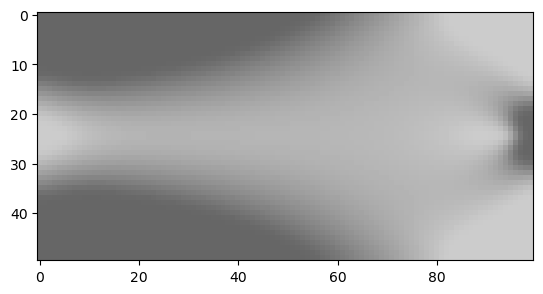

it: 5 | obj: 194.211 | Vol: 0.400 | ch: 0.171


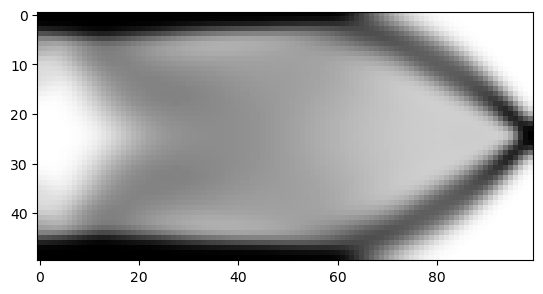

it: 20 | obj: 91.655 | Vol: 0.400 | ch: 0.200


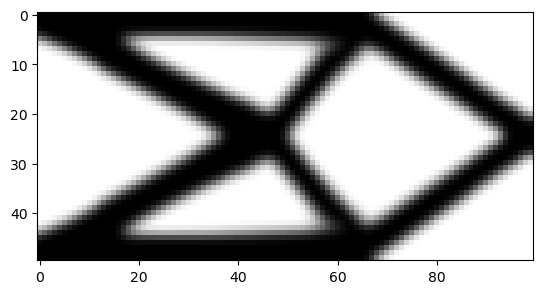

it: 215 | obj: 88.879 | Vol: 0.400 | ch: 0.010


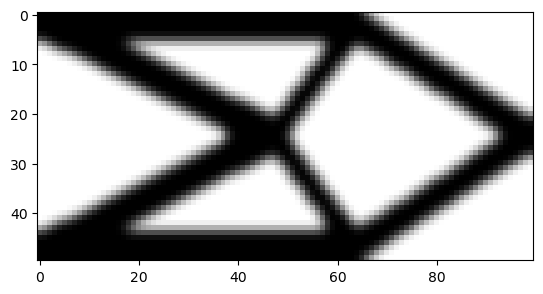

In [2]:
main(nelx=100,nely=50,volfrac=0.4,penal=3.0,rmin=2.5)

**Cantilever Beam Topology Optimized Result**

<img src="https://drive.google.com/uc?export=view&id=1Zt8ufvQCaG0C0sWQvpTVt4_qu0ZuAXum" width= 350px;/>

#### **Let's Study the Parameters**

Objective : Compare the topology results and its compliance value.

&nbsp;

Question 1 : **Is the design dependent on the mesh?**

Note that the radius of the filter must be increased in proportion to the discretization (in x, y).

- `main(nelx=100,nely=50,volfrac=0.4,penal=3.0,rmin=2.5)`
- `main(nelx= 80,nely=40,volfrac=0.4,penal=3.0,rmin=2.0)`
- `main(nelx= 60,nely=30,volfrac=0.4,penal=3.0,rmin=1.5)`

&nbsp;

Question 2 : **Influence of Volume Fraction?**

- `main(nelx=100,nely=50,volfrac=0.4,penal=3.0,rmin=2.5)`
- `main(nelx=100,nely=50,volfrac=0.3,penal=3.0,rmin=2.5)`
- `main(nelx=100,nely=50,volfrac=0.2,penal=3.0,rmin=2.5)`

&nbsp;

Question 3 : **Influence of Penal?**

- `main(nelx=100,nely=50,volfrac=0.4,penal=3.0,rmin=2.5)`
- `main(nelx=100,nely=50,volfrac=0.4,penal=1.0,rmin=2.5)`

&nbsp;

Question 4 : **Filter Analysis**

You can disable the filter by setting rmin to less than 1 or by making the filter inactive from the code.

- `main(nelx=100,nely=50,volfrac=0.4,penal=3.0,rmin=2.5)`
- `main(nelx=100,nely=50,volfrac=0.4,penal=3.0,rmin=1.0)`

&nbsp;

**Now, run more codes to gain insights from each parameter**


Minimum compliance problem with OC
ndesign        : 80 x 40
volfrac        : 0.4
penal          : 3.0
rmin           : 2.0
-----------------------------------------------
it: 1 | obj: 620.969 | Vol: 0.400 | ch: 0.200


/var/folders/9w/f1vm5w9x7dj14z_cd9g892m17jr7fh/T/ipykernel_54685/1454850475.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


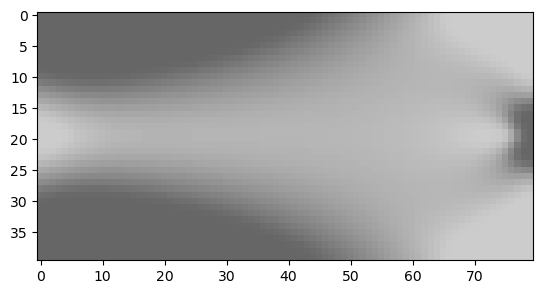

it: 5 | obj: 192.727 | Vol: 0.400 | ch: 0.173


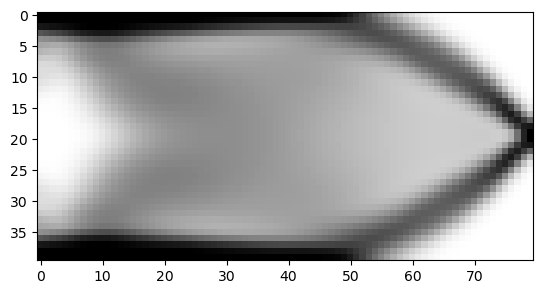

it: 20 | obj: 90.146 | Vol: 0.400 | ch: 0.200


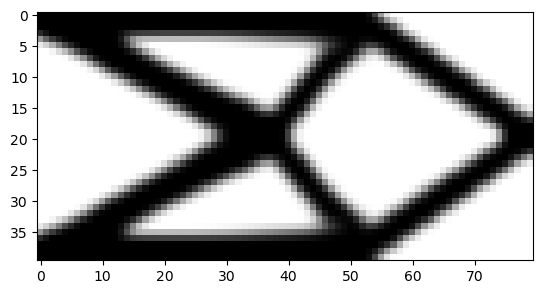

it: 213 | obj: 87.274 | Vol: 0.400 | ch: 0.009


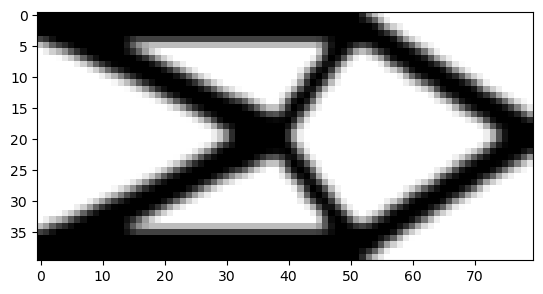

In [3]:
main(nelx= 80,nely=40,volfrac=0.4,penal=3.0,rmin=2.0)

Minimum compliance problem with OC
ndesign        : 60 x 30
volfrac        : 0.4
penal          : 3.0
rmin           : 1.5
-----------------------------------------------
it: 1 | obj: 617.855 | Vol: 0.400 | ch: 0.200


/var/folders/9w/f1vm5w9x7dj14z_cd9g892m17jr7fh/T/ipykernel_54685/1454850475.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


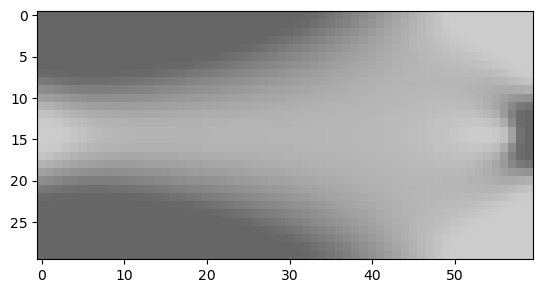

it: 5 | obj: 193.603 | Vol: 0.400 | ch: 0.172


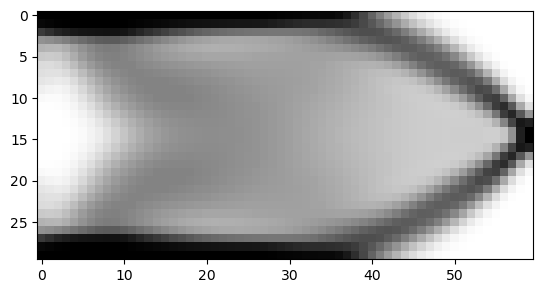

it: 20 | obj: 91.197 | Vol: 0.400 | ch: 0.200


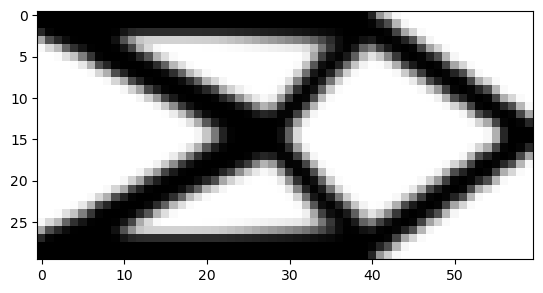

it: 193 | obj: 88.784 | Vol: 0.400 | ch: 0.009


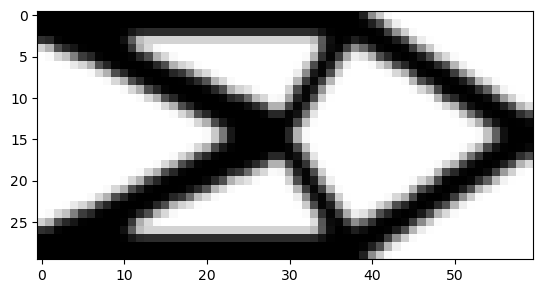

In [4]:
main(nelx= 60,nely=30,volfrac=0.4,penal=3.0,rmin=1.5)

&nbsp;

#### **Effect of Each Parameter**

&nbsp;

Question 1 : **Is the design dependent on the mesh?**

<img src="https://drive.google.com/uc?export=view&id=1IoygTLeYSue4jp3GYAJks5X75HLImGam" width= 600px;/>

- Mesh doesn't affect the optimized topology design.
- Mesh doesn't affect compliance value.
- A denser mesh provides a smoother result.

&nbsp;

Question 2 : **Influence of Volume Fraction?**

<img src="https://drive.google.com/uc?export=view&id=1S3wxPbEdurHpQBwP_auDcHdYqj3RHNzu" width= 600px;/>

- Volume fraction shows the percent of materials occupied in a domain.
- Lower volume fraction leads to a higher compliance value and vice versa.
- Higher compliance value leads to a higher amount of energy stored in a body under **elastic deformation** (less stiff).

&nbsp;

Question 3 : **Influence of Penal?**

<img src="https://drive.google.com/uc?export=view&id=1iPIkoZnr8_SA6syr8wizCILUFrzhD5Y7" width= 388px;/>

- Penalization ensure black and white solution.
- Without penalization, intermediate densities will occur in our solution. 
- Although `penal = 1.0` produces lower compliance value (better than `penal = 3.0`), but it has no meaning in manufacturability.

&nbsp;

Question 4 : **Filter Analysis**

<img src="https://drive.google.com/uc?export=view&id=1fy_tfHzDm4s2A_BxC1NuO-tmOiVPCwTH" width= 388px;/>

- Filter doesn't affect compliance value.
- Filter will provide a smoother topology solution and manufacturable.


---
### **Case II - Simply Supported Beam**

<img src="https://drive.google.com/uc?export=view&id=1PuT4U4q_SYSmGO9t-I_fiTeFLmIKkjXU" width= 600px;/>

- The design domain length ratio 3:1.
- The full design structure is supported with a pin and a roll at each ends with a with a mid-span vertically loaded.
- Each Node has 2 DOFS : horizontal and vertical.

&nbsp;

**Boundary Conditions**

`# Set load`<br>
`f[1,0]    = -1`

specifies a force of -1 at the second row of the vector f in the y direction of the first node. The force is acting downwards with magnitude value of 1.

&nbsp;

`# BC's and support`<br>
`dofs    = np.arange(2*(nelx+1)*(nely+1))`<br>
`fixed   = np.union1d(dofs[0:2*(nely+1):2],dofs[2*(nelx+1)*(nely+1)-1])`<br>
`free    = np.setdiff1d(dofs,fixed)`<br>

The code `dofs[0:2*(nely+1):2]` are x directions of all nodes to the left side of the structure and `dofs[2*(nelx+1)*(nely+1)-1]` is the y direction of the last node (right bottom corner). 

&nbsp;

**Run the code**

- `main(nelx=90,nely=30,volfrac=0.4,penal=3.0,rmin=2.5)`

Minimum compliance problem with OC
ndesign        : 90 x 30
volfrac        : 0.4
penal          : 3.0
rmin           : 2.5
-----------------------------------------------
it: 1 | obj: 1847.256 | Vol: 0.400 | ch: 0.200


/var/folders/9w/f1vm5w9x7dj14z_cd9g892m17jr7fh/T/ipykernel_54685/1454850475.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


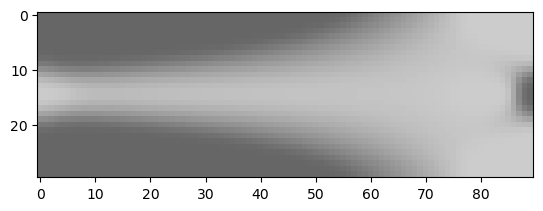

it: 5 | obj: 500.090 | Vol: 0.400 | ch: 0.169


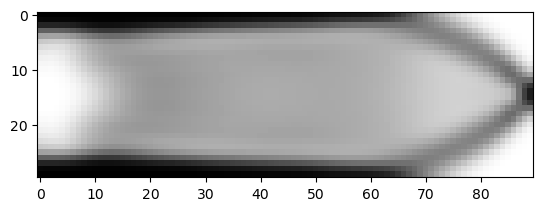

it: 20 | obj: 318.911 | Vol: 0.400 | ch: 0.169


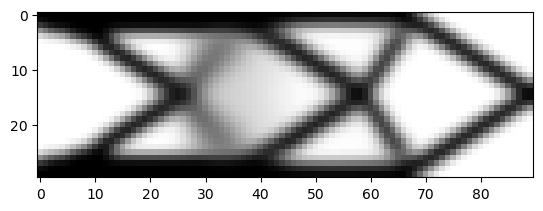

it: 138 | obj: 277.551 | Vol: 0.400 | ch: 0.010


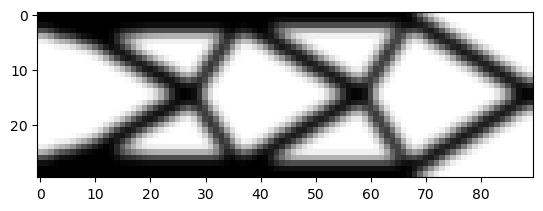

In [5]:
main(nelx=90,nely=30,volfrac=0.4,penal=3.0,rmin=2.5)

**Simply Supported Beam Topology Optimized Result**

<img src="https://drive.google.com/uc?export=view&id=14Z3oYXXT9CtV0Z6a8CDRqxX-Q-4xo8rr" width= 300px;/>

---
### **Case III - Bicycle Frame**

<img src="https://drive.google.com/uc?export=view&id=12aNREp08rpxpJLOcycLNkbb_-pAQLvuO" width= 350px;/>

- The reaction of the wheel produces a vertical force at the front.
- The bar under the saddle is recesse.
- The design domain length ratio 1:1.
- Each Node has 2 DOFS : horizontal and vertical.

&nbsp;

**Boundary Conditions**

`# Set load`<br>
`f[1,0]    = 1`

specifies a force of 1 at the second row of the vector f in the y direction of the first node. The force is acting upwards with magnitude value of 1.

&nbsp;

`# BC's and support`<br>
`dofs    = np.arange(2*(nelx+1)*(nely+1))`<br>
`fixed   = dofs[2*(nelx)*(nely+1):2*(nelx+1)*(nely+1):1]`<br>
`free    = np.setdiff1d(dofs,fixed)`<br>

The code `dofs[2*(nelx)*(nely+1):2*(nelx+1)*(nely+1):1]` are x directions of all nodes to the right side of the structure.

&nbsp;

**Run the code**

- `main(nelx=60,nely=60,volfrac=0.3,penal=3.0,rmin=2.5)`


Minimum compliance problem with OC
ndesign        : 60 x 60
volfrac        : 0.3
penal          : 3.0
rmin           : 2.5
-----------------------------------------------
it: 1 | obj: 338.751 | Vol: 0.300 | ch: 0.200


/var/folders/9w/f1vm5w9x7dj14z_cd9g892m17jr7fh/T/ipykernel_54685/1454850475.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


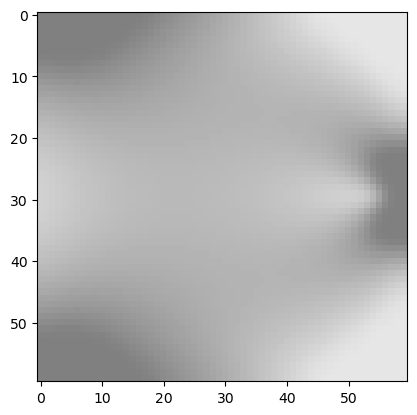

it: 5 | obj: 79.425 | Vol: 0.300 | ch: 0.200


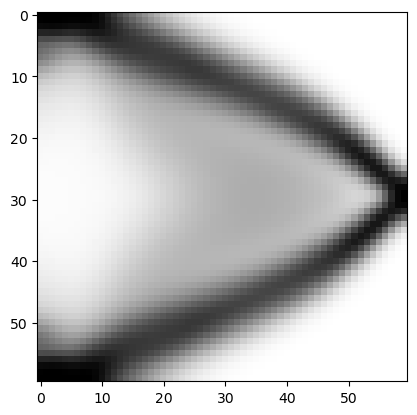

it: 20 | obj: 30.401 | Vol: 0.300 | ch: 0.152


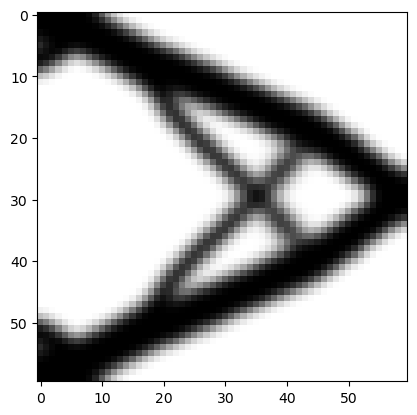

it: 316 | obj: 28.846 | Vol: 0.300 | ch: 0.010


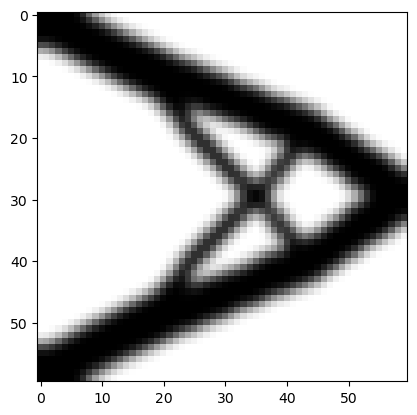

In [6]:
main(nelx=60,nely=60,volfrac=0.3,penal=3.0,rmin=2.5)

**Bicycle Frame Topology Optimized Result**

<img src="https://drive.google.com/uc?export=view&id=1vySmUv_pNeLK-vR3JH4Xfj_thHrwVBF2" width= 300px;/>

Minimum compliance problem with OC
ndesign        : 40 x 20
volfrac        : 0.3
penal          : 3
rmin           : 1.5
-----------------------------------------------
it: 1 | obj: 1453.427 | Vol: 0.300 | ch: 0.200
Minimum compliance problem with OC
ndesign        : 40 x 20
volfrac        : 0.4
penal          : 3
rmin           : 1.5
-----------------------------------------------
it: 1 | obj: 613.164 | Vol: 0.400 | ch: 0.200
Minimum compliance problem with OC
ndesign        : 40 x 20
volfrac        : 0.5
penal          : 3
rmin           : 1.5
-----------------------------------------------
it: 1 | obj: 313.940 | Vol: 0.500 | ch: 0.200
Minimum compliance problem with OC
ndesign        : 40 x 20
volfrac        : 0.6000000000000001
penal          : 3
rmin           : 1.5
-----------------------------------------------
it: 1 | obj: 181.678 | Vol: 0.600 | ch: 0.200
Minimum compliance problem with OC
ndesign        : 40 x 20
volfrac        : 0.7000000000000002
penal          : 3
rmin     

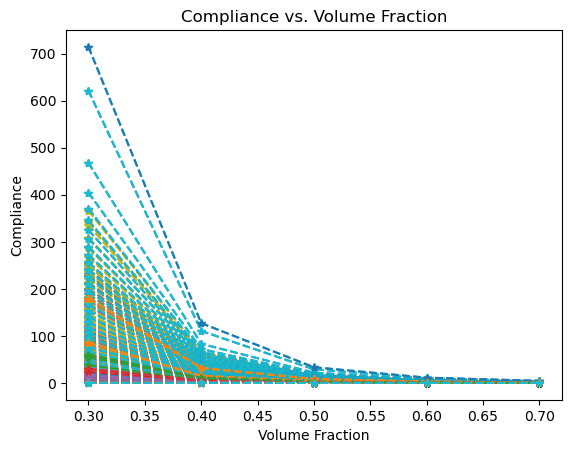

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
nelx = 40
nely = 20

volfracs = np.arange(0.3, 0.8, 0.1)  # Equivalent to 0.3:0.1:0.7 in MATLAB
p = 3
rmin = 1.5

compliance = []


# Loop through different volume fractions
for i, volfrac in enumerate(volfracs):
    ce, xPhys = main(nelx, nely, volfrac, p, rmin)
    compliance.append(ce)
    x=xPhys
    
   

# Plot compliance vs. volume fraction
plt.figure()
plt.plot(volfracs, compliance, '*--')
plt.xlabel('Volume Fraction')
plt.ylabel('Compliance')
plt.title('Compliance vs. Volume Fraction')
plt.show()